In [237]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import re


## АПТЕКА анализ ассортимента

Задачи:  
1. Проведите ABC-анализ продаж по количеству проданных штук товара. Сколько товаров вносят 80% вклад в общее количество проданных штук? Соблюдается ли классическое правило Парето, на котором базируется ABC-анализ? Если нет, то почему такое может быть и что нужно делать, чтобы приблизиться к этой пропорции?  

2. Выведите топ-20 пар товаров, которые чаще всего встречаются друг с другом в чеках. Исключите очевидные связки - пакеты, карты лояльности и прочее. Предложите 2-3 акции для повышения среднего чека на основании полученных результатов.

3. Напишите функцию, которая будет принимать произвольный промежуток дат и признак для анализа - выручку, количество продаж или прибыль. Функция должна возвращать таблицу с ТОП-10 товаров по выбранном признаку за выбранный промежуток времени. Нужно выводить название товара, сумму продаж, прибыль с продаж, количество проданных штук, а также динамику по каждой метрике относительно предыдущего аналогичного по длительности периода.  


Есть данные о продаже препаратов в аптечной сети. 
Описание данных: 

- DR_Dat - дата покупки
- DR_Tim - время покупки
- DR_NChk - номер чека
- DR_NDoc - номер кассового документа
- DR_Shop (фактически: dr_apt) - номер магазина 
- DR_Kkm - номер кассового аппарата
- DR_TDoc - вид документа
- DR_TPay - форма платежа (18 - безнал, 15 - нал)
- DR_CGoods - артикул товара
- DR_NGoods - название товара
- DR_Kol - кол-во проданного товара
- DR_CZak - закупочная цена
- DR_CRoz - розничная цена
- DR_SDisc - сумма скидки
- DR_CDisc - код скидки
- DR_BCDisc - штрихкод скидки
- DR_TabEmpl - табельный номер сотрудника
- DR_Pos - номер позиции в чеке
- DR_VZak - вид закупки (1 - обычный, 2 - интернет-заказ)


In [200]:
df =  pd.read_excel('C:/Users/OLEG/Jupyter/Simu/sales-exl.xlsx')

In [201]:
# Установка максимального количества отображаемых столбцов
pd.set_option('display.max_columns', None)
df.head(3)

,dr_dat,dr_tim,dr_nchk,dr_ndoc,dr_apt,dr_kkm,dr_tdoc,dr_tpay,dr_cdrugs,dr_ndrugs,dr_suppl,dr_prod,dr_kol,dr_czak,dr_croz,dr_sdisc,dr_cdisc,dr_bcdisc,dr_tabempl,dr_pos,dr_vzak
0,2022-05-01,08:33:09,6251,7001554,7,22553,Розничная реализация,18,20398,"ОТРИВИН 0,1% 10МЛ. №1 НАЗАЛ.СПРЕЙ ФЛ...",Фармкомплект ООО,Новартис Консьюмер Хелс С.А.,1.0,146.0,175.0,8.0,9.0,2.000100e+11,37,1,1
1,2022-05-01,09:03:32,4659,6002284,6,22568,Розничная реализация,18,541023,РАСТОРОПШИ ШРОТ 100Г. ПОР. /ИВАН ДА ...,Катрен г.Химки,ИВАН ДА МАРЬЯ ООО,2.0,38.62,67.0,16.0,35.0,2.000000e+11,27,1,1
2,2022-05-01,09:07:49,6077,2002811,2,22569,Розничная реализация,18,25634,АККУ-ЧЕК ТЕСТ-ПОЛОСКИ АКТИВ №50 [ACC...,Катрен г.Химки,РОШ ДИАБЕТС КЕА ГМБХ,1.0,1107.57,1363.0,0.0,NaN,NaN,25,1,1


#### ПРОВЕРКА ДАННЫХ

При первом выводе видны проблемы:
- dr_czak содержит даты, 
- ниже видим, что часть данных имеет неправильный тип (object для числовых данных)

Смотрю тип данных: потребуется изменение для ряда позиций

Проверяю дубликаты

Вывожу список значений: проверяю наличие "выбросов"

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45128 entries, 0 to 45127
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dr_dat      45128 non-null  datetime64[ns]
 1   dr_tim      45128 non-null  object        
 2   dr_nchk     45128 non-null  int64         
 3   dr_ndoc     45128 non-null  int64         
 4   dr_apt      45128 non-null  int64         
 5   dr_kkm      45128 non-null  int64         
 6   dr_tdoc     45128 non-null  object        
 7   dr_tpay     45128 non-null  int64         
 8   dr_cdrugs   45128 non-null  int64         
 9   dr_ndrugs   45128 non-null  object        
 10  dr_suppl    45128 non-null  object        
 11  dr_prod     45128 non-null  object        
 12  dr_kol      45128 non-null  object        
 13  dr_czak     45128 non-null  object        
 14  dr_croz     45128 non-null  object        
 15  dr_sdisc    45128 non-null  object        
 16  dr_cdisc    17936 non-

In [203]:
df.duplicated().sum()
# дубликатов нет - хорошо

0

Pandas должен сам распознавать такие строки как время, поэтому пока не трогаем

def to_datetime_time(time_str):
    try:
        return datetime.time.strptime(time_str, "%H:%M:%S")
    except ValueError:
        return None

df['dr_tim'] = df['dr_tim'].apply(to_datetime_time)

In [204]:
columns_to_convert = ['dr_kol', 'dr_czak', 'dr_croz', 'dr_sdisc']
df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce')


--------------------------------
Аналитика по столбцу dr_apt
count    45128.000000
mean        11.157552
std          5.737284
min          2.000000
25%          6.000000
50%         13.000000
75%         17.000000
max         18.000000
Name: dr_apt, dtype: float64


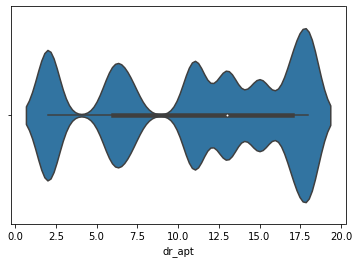

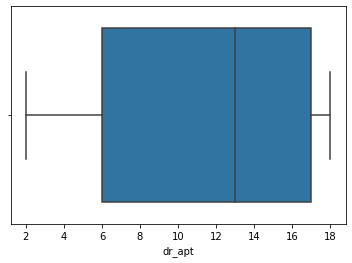

--------------------------------
Аналитика по столбцу dr_kol
count    45123.000000
mean         1.077304
std          1.394307
min         -1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        200.000000
Name: dr_kol, dtype: float64


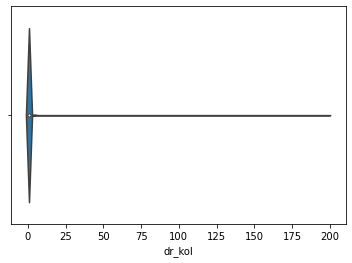

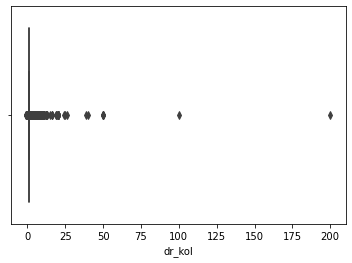

--------------------------------
Аналитика по столбцу dr_czak
count    40535.000000
mean       261.374071
std        416.761493
min          0.010000
25%         47.400000
50%        126.170000
75%        323.665000
max      17734.100000
Name: dr_czak, dtype: float64


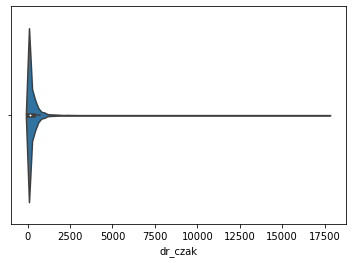

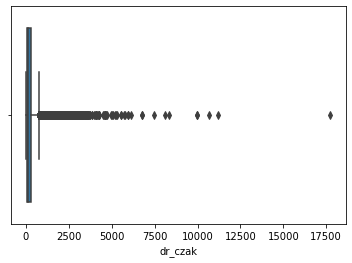

--------------------------------
Аналитика по столбцу dr_croz
count    45097.000000
mean       299.436869
std        477.954455
min          0.010000
25%         51.000000
50%        135.000000
75%        378.000000
max      18281.300000
Name: dr_croz, dtype: float64


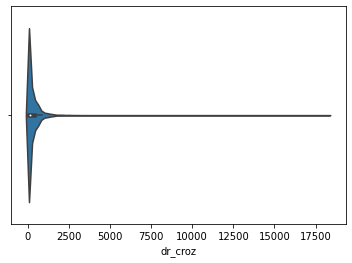

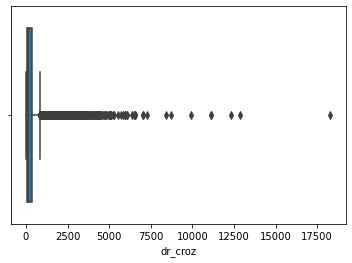

--------------------------------
Аналитика по столбцу dr_pos
count    45128.000000
mean         2.555797
std          2.747769
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         50.000000
Name: dr_pos, dtype: float64


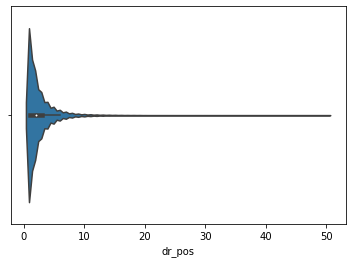

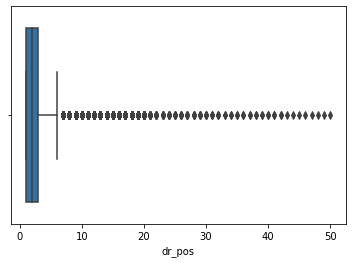

In [206]:
#применю свой цикл из предыдущих работ для описания числовых переменных

Ints = ['dr_apt', 'dr_kol', 'dr_czak', 
        'dr_croz', 'dr_pos']

for i in Ints:
    print('--------------------------------')
    print('Аналитика по столбцу', i)
    print(df[i].describe())
    sns.violinplot(x=df[i])
    plt.show()
    sns.boxplot(x=df[i])
    plt.show()

In [223]:
#магазины и число продаж в них
shop_rating = df_2.groupby('dr_apt').agg(pts_sales=('dr_apt', 'count'))
shop_rating.head()

,pts_sales
dr_apt,
2,7768
6,4884
7,3208
11,6451
13,5226


ПРОМЕЖУТОЧНАЯ АНАЛИТИКА

DR_Shop (dr_apt) - номер магазина 
У нас 17 номеров магазинов (со  2 по 18 номера)
Число строк разное для разных магазинов
Доп таблица показала что работают 5 из них, продажи в шт различаются более чем в 2 раза в лучшем и худшем

DR_Kol - кол-во проданного товара
Есть странные значения -1 (возможно это возврат) 
Покупка более 1 единицы крайне редкая.

DR_CZak - закупочная цена
50% стоят в закупке в диапазоне от 47 до 323 рублей. Среднее 261, медиана 126. Это говорит о том, что есть очень дорогие препараты, повышающие среднюю цену более чем в 2 раза

DR_CRoz - розничная цена
50% в диапазоне 51 - 378 руб, средняя 299, медиана 135.
Таким образом, наценка составляет 7 - 17% (оценка по квартилям) без учета скидок. В среднем наценка выше для более дорогих позиций.

DR_Pos - номер позиции в чеке
в 75% случаев покупают до 3х позиций. Медиана - 2 позиции

In [207]:
df.groupby('dr_kol').agg({'dr_kol': 'count'})

#у нас 4 раза значения -1. Нужно уточнить может ли такое быть (возврат?), 
#но сейчас я сделаю допущение, что это ошибка и правильное значение 1


,dr_kol
dr_kol,
-1.000000,4
0.006479,3
0.008504,1
0.010000,12
0.013734,1
0.019608,1
0.020000,19
0.020380,3
0.025341,1


In [208]:
df['dr_kol'] = df['dr_kol'].abs()

In [228]:
#удаляю товары которые не относятся напрямую к ассортименту с которым нам нужно работать и давать рекомендации
#это часть требования задачи 2, но представляется, что это правильно сделать сразу, чтобы не вносить шум в данные
#сначала я вывел все уникальные названия, но с ними тяжело работать, 
#поэтому отобрал только те которые включали слова 'пакет', 'карта', 'сертификат', 'подарок' 

keywords = ['пакет', 'карта', 'сертификат', 'подарок']

# Создаем регулярное выражение для поиска любого из ключевых слов
pattern = '|'.join(keywords)

# Фильтруем уникальные значения в столбце 'dr_ndrugs' по регулярному выражению
filtered_values = df[df['dr_ndrugs'].str.contains(pattern, case=False, regex=True)]['dr_ndrugs'].unique()

# Выводим отфильтрованные значения
for value in filtered_values:
    print(value)

КАРТАЛИН КРЕМ Д/ТЕЛА ПРИ ПСОРИАЗЕ 100МЛ. ТУБА
ГОРЧИЧНИКИ-ПАКЕТ №20
ЛЕЙКОПЛАСТЫРЬ 1Х500 РУЛОН КОНТ.УПАКОВКА/ПАКЕТ /ВЕРОФАРМ/
ПАКЕТ ГИПОТЕРМИЧЕСКИЙ/ОХЛАЖД. СНЕЖОК №2 (Д/ОКАЗАН. ПЕРВ. ПОМОЩИ) /ФЭСТ/
ГОРЧИЧНИКИ-ПАКЕТ ЭВКАЛИПТ.МАСЛО №20 /ПЕТРОФАРМ/
ГОРЧИЧНИК-ПАКЕТ ЭКОНОМ №20 /РУДАЗ/
ПАКЕТ ПЕРЕВЯЗОЧНЫЙ С 2-МЯ ПОДУШЕЧКАМИ СТЕР.
СПЛАТ KIDS ЗУБНАЯ ЩЕТКА Д/ДЕТЕЙ (1204-02-01) Х 1 АКЦИЯ ПАКЕТ (4)
КОНТУР ТС ТЕСТ-ПОЛОСКИ №50Х3УП. (50х2+50 ПОДАРОК) [COUNTOUR TS]


In [227]:
indexes_to_drop = df[df['dr_ndrugs'].isin(['Карта LOYALITY 0,01Р', 'ПАКЕТ МАЙКА №1', 'ПАКЕТ', 'Карта LOYALITY 25Р'])].index

# Удаляем найденные строки
df = df.drop(indexes_to_drop)

#проверил правильность перезапуском предыдущей ячейки. Все удалилось корректно

#### ПРЕДВАРИТЕЛЬНЫЙ АНАЛИЗ ЗАВЕРШЕН

#### ЗАДАЧА 1

Проведите ABC-анализ продаж по количеству проданных штук товара. Сколько товаров вносят 80% вклад в общее количество проданных штук? Соблюдается ли классическое правило Парето, на котором базируется ABC-анализ? Если нет, то почему такое может быть и что нужно делать, чтобы приблизиться к этой пропорции? 


Для этой задачи нужно решить проблему дробных значений в переменной dr_kol 
Это либо ошибка ввода, либо какие-то специфические единицы изменения (например, граммы или кг при продаже весового товара)
В работе я бы уточнил этот вопрос, но сейчас я исключу их из рассчета. 

In [212]:
df['dr_kol_int'] = np.where(df['dr_kol'] == df['dr_kol'].apply(np.floor), df['dr_kol'], np.nan)

In [213]:
pareto = df.groupby('dr_cdrugs').agg({'dr_kol_int': ['count', 'sum']})

# Убираем мультииндекс
pareto.columns = pareto.columns.droplevel()

# Переименовываем колонки
pareto.rename(columns={'count': 'Sales_Count', 'sum': 'Sales_Sum'}, inplace=True)

In [214]:
pareto = pareto.sort_values(by='Sales_Sum', ascending=False)
pareto['Sum_Cum'] = pareto['Sales_Sum'].cumsum()

In [215]:
pareto['Sum_Cum_%'] = (pareto['Sum_Cum'] / pareto['Sales_Sum'].sum())*100

In [217]:
#Кодируем артикулы по группам

def group(sum_cum):
    if sum_cum <= 80:
        return 'A'
    elif sum_cum <= 95:
        return 'B'
    else:
        return 'C'

pareto['Group'] = pareto['Sum_Cum_%'].apply(group)

In [218]:
total_sales_sum = pareto['Sales_Sum'].sum()
num_rows = pareto.shape[0]
result_1 = pareto.groupby('Group').agg({'Sales_Sum': 
                                        ['sum', lambda x: x.sum() / total_sales_sum,
                                       'count', lambda y: y.count() / num_rows]})

result_1.columns = ['Sales', 'Share of Sales', 'Count', 'Share of Count']

print(result_1)

         Sales  Share of Sales  Count  Share of Count
Group                                                
A      38230.0        0.799908   1686        0.259425
B       7173.0        0.150085   2379        0.366056
C       2390.0        0.050007   2434        0.374519


#### ЗАДАЧА 1: ВЫВОДЫ

Распределение групп близко к идеальному (в скобках) распределению Парето:
- 27(20)% артикулов дают 80% продаж
- 36(30)%                15% 
- 37(50)%                 5%

Мы видим, что группы А и В несколько больше идеальных, но незначительно.

В целом, мне кажется, что применять правило Парето к ассортименту аптеки некорретно.
Мы говорим о товарах вынужденного потребления. Т.е. их покупают не для удовольствия, а для исправления проблемы (со здоровьем).
Поэтому распределение продаж по артикулам зависит не от порулярности брендов и предпочтений потребителей, а от видов заболеваний, знаний докоторов, широты и специализации ассортимента лекарств для разных заболеваний.

Это правило корректно применять например к гигиенической части ассортимента аптеки.

Управление ценой может помогать нам в конкрурентной борьбе с другими аптеками, но неочевидно что оно способно переключать между разными артикулами.

Варианты которые можно проверить: 
- Специфика продаж в оффлайн и онлайн каналах


In [219]:
pareto.reset_index(inplace=True)

df = df.merge(pareto[['dr_cdrugs', 'Group']], on='dr_cdrugs', how='left')

In [220]:
# Создание сводной таблицы с общим количеством для каждой категории 'dr_vzak' и значения 'Group'
result_channel = df.groupby(['dr_vzak', 'Group']).size().unstack(fill_value=0)

# Добавление столбца с общим количеством для каждой категории 'dr_vzak'
result_channel['total'] = result_channel.sum(axis=1)

# Рассчет долей A, B и C от общего количества для каждой категории 'dr_vzak'
result_channel['A_ratio'] = result_channel['A'] / result_channel['total']
result_channel['B_ratio'] = result_channel['B'] / result_channel['total']
result_channel['C_ratio'] = result_channel['C'] / result_channel['total']

# Вывод результата
print('Структура продаж по каналам')
print(result_channel)


Структура продаж по каналам
Group        A     B     C  total   A_ratio   B_ratio   C_ratio
dr_vzak                                                        
1        33529  6499  2676  42704  0.785149  0.152187  0.062664
2         1006   595   435   2036  0.494106  0.292240  0.213654


#### ЗАДАЧА 1: ДОПОЛНИТЕЛЬНЫЙ ВЫВОД

Мы видим, что структура в интернет канале сильно отличается: заметный перекос в сторону товаров B C групп по классификации всей сети (но возможно, в интернет канале есть своя структура, которая сильно отличается и позволяет строить свою  А В С матрицу).
Мы видим, что товары которые хуже продаются в традиционной рознице делают больший вклад в онлайн торговлю. Возможно, это более редкие позиции которые не всегда представлены в традиционной рознице и потребители их заказывают.



#### ЗАДАЧА 2: 
Выведите топ-20 пар товаров, которые чаще всего встречаются друг с другом в чеках. Исключите очевидные связки - пакеты, карты лояльности и прочее. Предложите 2-3 акции для повышения среднего чека на основании полученных результатов.


Решение:

Первый вариант, который оказался бесконечным:
- Переберем все парные комбинации артикулов, посчитаем количество таких совпадений
- Составим рейтинг, отберем 20 наиболее высоких пар

Второй вариант:
- Отфильтровать только покупки где 2 и более товаров (сокращаем базу, удаляем ненужные чеки, обработка которых нам бесполезна)
- Делаем рейтинг по магазину с невысокими продажами - этот план тоже не сработал - слишком долго
- Делаем рейтинг по 10/15/45 самым популярным товарам. 
- Смотрим как меняется рейтинг и принимаем максимальный за приближенно верный.


Строго говоря, уровень ограничения, чтобы быть уверенным, что мы не потеряли ни одной пары следующий.

Число покупок 20й пары должно быть выше чем число покупок одного препарата. Например, на 20 месте у нас пара с количеством покупок 500, тогда все товары с числом покупком 499 и меньше мы можем удалить. 

Это итерационный алгоритм, но думаю будет достаточно более простого решения 

In [221]:
#функция вывода топовых пар
def toppairs(dff): 
    pairs = pd.DataFrame(columns=['Code 1', 'Name 1', 'Code 2', 'Name 2', 'Pairs'])

    for i, value_1 in enumerate(dff['dr_cdrugs'].unique()):
        for j, value_2 in enumerate(dff['dr_cdrugs'].unique()):
            if i < j:  # Проверяем, что value_1 меньше value_2
                cnt = 0
                for check in dff['dr_nchk'].unique():
                    if ((dff[(dff['dr_nchk'] == check) & (dff['dr_cdrugs'] == value_1)].shape[0] > 0) and 
                        (dff[(dff['dr_nchk'] == check) & (dff['dr_cdrugs'] == value_2)].shape[0] > 0)):
                        cnt += 1
                # Добавляем новую строку в датафрейм
                pairs.loc[len(pairs)] = [value_1, dff[dff['dr_cdrugs'] == value_1]['dr_ndrugs'].iloc[0],
                                          value_2, dff[dff['dr_cdrugs'] == value_2]['dr_ndrugs'].iloc[0],
                                          cnt]
    # Сортируем и выводим первые строки
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_colwidth', 20)
    print(pairs.sort_values(by='Pairs', ascending=False).head(20))




In [230]:
#Выделяем только чеки с 2 и более товарами

two = df.groupby('dr_nchk').agg(pts=('dr_nchk','count'))

two = two[two['pts'] > 1]

#формируем датафрейм в котором чеки с 2 и более товарами
df_2 = df.merge(two, on='dr_nchk', how='right')

In [224]:
#это попытка анализа по самому "маленькому в продажах" магазину
#df_2_shop_7 = df[df['dr_apt'] == 7]
#toppairs(df_2_shop_7)

#считает очень долго ))) лучше на запускать 

In [225]:
#Функция для формирования базы из заданного числа топовых товаров

def top_choice(df_tc, n):
    df_top = df_tc.groupby('dr_cdrugs').agg(popular=('dr_nchk','count'))
    df_top = df_top.sort_values(by='popular', ascending=False)
    df_top.head()
    df_top = df_top[:n]
    df_tc = df_tc[df_tc['dr_cdrugs'].isin(df_top.index)]
    return df_tc



In [231]:
#df_2 два и более товаров в чеке

df_3 = top_choice(df_2, 5) #оставляем в базе только заданное число топовых товаров
toppairs(df_3) #считаем пары между ними

   Code 1               Name 1  Code 2               Name 2 Pairs
8  142036  ПЕНТАЛГИН №24 ТА...   72392  СНУП 0,1% 90МКГ/...    20
0  418134  ВАЛИДОЛ 60МГ. №1...  393397  КОРВАЛОЛ 25МЛ. К...    16
4  393397  КОРВАЛОЛ 25МЛ. К...  142036  ПЕНТАЛГИН №24 ТА...    14
6  393397  КОРВАЛОЛ 25МЛ. К...   72392  СНУП 0,1% 90МКГ/...     8
1  418134  ВАЛИДОЛ 60МГ. №1...  142036  ПЕНТАЛГИН №24 ТА...     6
7  142036  ПЕНТАЛГИН №24 ТА...  496504  НАФТИЗИН 0,1% 15...     5
2  418134  ВАЛИДОЛ 60МГ. №1...  496504  НАФТИЗИН 0,1% 15...     3
3  418134  ВАЛИДОЛ 60МГ. №1...   72392  СНУП 0,1% 90МКГ/...     3
5  393397  КОРВАЛОЛ 25МЛ. К...  496504  НАФТИЗИН 0,1% 15...     3
9  496504  НАФТИЗИН 0,1% 15...   72392  СНУП 0,1% 90МКГ/...     2


In [140]:
df_3 = top_choice(df_2, 25)
toppairs(df_3)

     Code 1               Name 1  Code 2               Name 2 Pairs
153  393397  КОРВАЛОЛ 25МЛ. К...  444920  ПУСТЫРНИКА НАСТО...    30
187  142036  ПЕНТАЛГИН №24 ТА...   72392  СНУП 0,1% 90МКГ/...    20
189  142036  ПЕНТАЛГИН №24 ТА...    2302  ОМЕЗ 20МГ. №30 К...    19
129  418134  ВАЛИДОЛ 60МГ. №1...  393397  КОРВАЛОЛ 25МЛ. К...    16
186  142036  ПЕНТАЛГИН №24 ТА...  377588  ТИЗИН КЛАССИК 0,...    15
93   393314  ЦИТРАМОН П №20 Т...  345578  ПАРАЦЕТАМОЛ 500М...    15
148  393397  КОРВАЛОЛ 25МЛ. К...  142036  ПЕНТАЛГИН №24 ТА...    14
68   318348  СФМ ШПРИЦ 5МЛ. 3...  339757  ЦЕФТРИАКСОН 1Г. ...    12
164  345578  ПАРАЦЕТАМОЛ 500М...  142036  ПЕНТАЛГИН №24 ТА...    12
272   72392  СНУП 0,1% 90МКГ/...   18836  ТАУФОН 4% 10МЛ. ...    11
82   345211  ОМЕПРАЗОЛ 20МГ. ...   72392  СНУП 0,1% 90МКГ/...    11
182  142036  ПЕНТАЛГИН №24 ТА...  196444  РИНОСТОП 0,1% 15...    11
121   46046  РОМАШКИ ЦВЕТКИ 1...   72392  СНУП 0,1% 90МКГ/...    11
266  377588  ТИЗИН КЛАССИК 0,...    2302  ОМЕЗ 2

In [144]:
#выдача 20 наиболее популярных пар из 50 самых популярных лекарств

df_3 = top_choice(df_2, 50)
toppairs(df_3)

     Code 1               Name 1  Code 2               Name 2 Pairs
530  393397  КОРВАЛОЛ 25МЛ. К...  444920  ПУСТЫРНИКА НАСТО...    30
605  142036  ПЕНТАЛГИН №24 ТА...   72392  СНУП 0,1% 90МКГ/...    20
607  142036  ПЕНТАЛГИН №24 ТА...    2302  ОМЕЗ 20МГ. №30 К...    19
558  393397  КОРВАЛОЛ 25МЛ. К...  444665  ВАЛЕРИАНЫ НАСТОЙ...    17
484  418134  ВАЛИДОЛ 60МГ. №1...  393397  КОРВАЛОЛ 25МЛ. К...    16
327  393314  ЦИТРАМОН П №20 Т...  345578  ПАРАЦЕТАМОЛ 500М...    15
604  142036  ПЕНТАЛГИН №24 ТА...  377588  ТИЗИН КЛАССИК 0,...    15
588  345578  ПАРАЦЕТАМОЛ 500М...  345542  АЦЕТИЛСАЛИЦИЛОВА...    14
523  393397  КОРВАЛОЛ 25МЛ. К...  142036  ПЕНТАЛГИН №24 ТА...    14
846  444920  ПУСТЫРНИКА НАСТО...  444665  ВАЛЕРИАНЫ НАСТОЙ...    13
841  444920  ПУСТЫРНИКА НАСТО...  439244  БОЯРЫШНИКА НАСТО...    13
188  318348  СФМ ШПРИЦ 5МЛ. 3...  339757  ЦЕФТРИАКСОН 1Г. ...    12
559  345578  ПАРАЦЕТАМОЛ 500М...  142036  ПЕНТАЛГИН №24 ТА...    12
380   46046  РОМАШКИ ЦВЕТКИ 1...   72392  СНУП 0

#### ЗАДАЧА 2: ВЫВОДЫ

Наиболее популярные пары связаны с: 
- Заболеванием сердца, обезболивающими/жаропонижающими и средствами от заложенности носа (простуды / вирусных заболеваний)

Возможные акции для повышения продаж:
- Скидки за комплект на определенные комбинации - для стимулирования покупки второго препарата в пару к первому. при этом можно промотировать более дорогой: например  пенталгин + СНУП. Одновременно побуждаем купить второй или купить вместо пенталгин + Нафтизин (СНУП дороже)
- Разработать памятку для провизоров: при покупке Пенталгина или аналога, уточнять что болит и предлагать второе более точечное лекарство. Мотивировать провизоров продавать пары.
- Разработать пары средств: сильнодействующее + натуральное и продавать их по спец цене. Например: Корвалол + Пустырник, Нимесил + Активированный уголь и т.д.

#### ЗАДАЧА 3: 

Напишите функцию, которая будет принимать произвольный промежуток дат и признак для анализа - выручку, количество продаж или прибыль. Функция должна возвращать таблицу с ТОП-10 товаров по выбранном признаку за выбранный промежуток времени. Нужно выводить название товара, сумму продаж, прибыль с продаж, количество проданных штук, а также динамику по каждой метрике относительно предыдущего аналогичного по длительности периода. 


In [232]:
#функция для построения таблицы

def table_10(dff, date_start, date_finish, word):        
                # Расчет разности между датами
        date_diff = date_finish - date_start

        # Вычисление новой начальной даты
        date_prev = date_start - date_diff
        
        print(f'Суммы {word} по 10 наиболее популярным позициям за период c {date_start} '
      f'по {date_finish}.'  
      f'В сравнении с периодом с {date_prev} по {date_start}')
        
        df_act = dff[(dff['dr_dat'] >= date_start) & (dff['dr_dat'] <= date_finish)]
        df_act ['profit'] = group_df_act = df_act.groupby('dr_cdrugs').agg({'param': ['sum']})

        df_prev = dff[(dff['dr_dat'] >= date_prev) & (dff['dr_dat'] <= date_start)]
        group_df_prev = df_prev.groupby('dr_cdrugs').agg({'param': ['sum']})

        group_df_full = pd.merge(group_df_prev, group_df_act, on='dr_cdrugs', how='right')

        group_df_full.columns = ['Previous', 'Actual']

        group_df_full = group_df_full.sort_values(by='Actual', ascending=False)

        group_df_10 = group_df_full[:9]
        
        group_df_10['Dinamic'] = group_df_10['Actual'] - group_df_10['Previous']  

        group_df_10_with_names = group_df_10.merge(df[['dr_cdrugs', 'dr_ndrugs']].drop_duplicates(), on='dr_cdrugs', how='left')

        pd.set_option('display.max_colwidth', 40)
        print(group_df_10_with_names[['dr_ndrugs', 'Previous', 'Actual', 'Dinamic']])  

       

In [233]:
#функция для настройки параметров в зависимости от требуемой величины 

def compare(date_start, date_finish, type):
    date_start = datetime.strptime(date_start, '%Y-%m-%d')
    date_finish = datetime.strptime(date_finish, '%Y-%m-%d')
    
    if type == 'Sales':
        df['param'] = df['dr_croz']
        table_10(df, date_start, date_finish, 'выручки') 
        
    if type == 'Profit':
        df['param'] = df['dr_croz'] - df['dr_czak']
        table_10(df, date_start, date_finish, 'прибыли') 
        
    if type == 'Quality':
        df['param'] = df['dr_kol']
        table_10(df, date_start, date_finish, 'продаж в штуках')     


In [234]:
# Sales Profit Quantity   
compare('2022-05-01', '2022-05-05', 'Sales') 

Суммы выручки по 10 наиболее популярным позициям за период c 2022-05-01 00:00:00 по 2022-05-05 00:00:00.В сравнении с периодом с 2022-04-27 00:00:00 по 2022-05-01 00:00:00
                                 dr_ndrugs  Previous   Actual  Dinamic
0  НИМЕСИЛ 100МГ. 2Г. №30 ГРАН. Д/СУСП....    4812.0  30014.0  25202.0
1    КСАРЕЛТО 20МГ. №98 ТАБ. П/П/О /БАЙЕР/   22210.0  22210.0      0.0
2     ПЕНТАЛГИН №24 ТАБ. П/П/О /ОТИСИФАРМ/    4030.0  15779.0  11749.0
3         ДЕТРАЛЕКС 1000МГ. №60 ТАБ. П/П/О       NaN  12716.0      NaN
4  ЭНТЕРОСГЕЛЬ 225Г. ПАСТА Д/ПРИЕМА ВНУ...    1942.0  10139.0   8197.0
5             ВИАГРА 100МГ. №12 ТАБ. П/П/О    9886.0   9886.0      0.0
6  ТЕРАФЛЮ ЛИМОН ОТ ГРИППА И ПРОСТУДЫ №...    2737.0   9016.0   6279.0
7  ТЕРАФЛЮ ЛИМОН ОТ ГРИППА И ПРОСТУДЫ 2...    2737.0   9016.0   6279.0
8                КОНВАЛИС 300МГ. №50 КАПС.    2214.0   8838.0   6624.0
9               ФЕМАРА 2,5МГ. №30 ТАБ. П/О       NaN   8706.0      NaN


C:\Users\OLEG\AppData\Local\Temp/ipykernel_10796/1474817363.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_act ['profit'] = group_df_act = df_act.groupby('dr_cdrugs').agg({'param': ['sum']})
C:\Users\OLEG\AppData\Local\Temp/ipykernel_10796/1474817363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df_10['Dinamic'] = group_df_10['Actual'] - group_df_10['Previous']
